# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

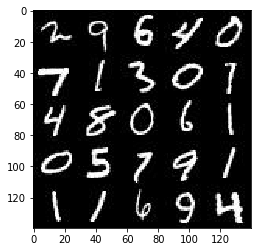

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

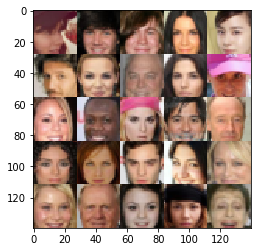

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.5.0
Default GPU Device: /device:GPU:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    inputs_real = tf.placeholder(tf.float32, shape=(None, image_width, image_height, image_channels), name='inputs_real')
    inputs_z = tf.placeholder(tf.float32, shape=(None, z_dim), name='inputs_z')
    learning_rate = tf.placeholder(tf.float32, shape=(None), name='learning_rate')

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [7]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):

        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        x1 = tf.maximum(alpha * x1, x1)
                
        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha * x2, x2)
        
        flat = tf.reshape(x2, (-1, 7*7*128))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [15]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha=0.2
    with tf.variable_scope('generator', reuse = not is_train):
        x1 = tf.layers.dense(z, 7*7*128)
        
        x1 = tf.reshape(x1, (-1, 7, 7, 128))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d_transpose(x1, 64, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)

        logits = tf.layers.conv2d_transpose(x2, out_channel_dim, 5, strides=2, padding='same')
        
        out = tf.tanh(logits)
        
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [16]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [17]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    d_vars = tf.trainable_variables('discriminator')
    g_vars = tf.trainable_variables('generator')
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [18]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [44]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    _, image_width, image_heigth, image_channels = data_shape
    out_channel_dim =  data_shape[-1]
    
    input_real, input_z, learning_rate_placeholder = model_inputs(image_width, image_heigth, image_channels, z_dim)
        
    d_loss, g_loss = model_loss(input_real, input_z, out_channel_dim)
        
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate_placeholder, beta1)
    
    steps = 0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, learning_rate_placeholder: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, learning_rate_placeholder: learning_rate})

                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                
                if steps % 25 == 0:    
                    show_generator_output(sess, 25, input_z, out_channel_dim, data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.3625... Generator Loss: 3.9984
Epoch 1/2... Discriminator Loss: 5.4255... Generator Loss: 4.6667


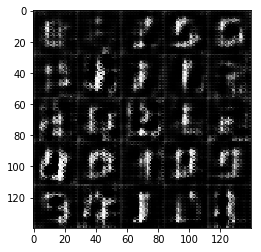

Epoch 1/2... Discriminator Loss: 2.2718... Generator Loss: 0.9534
Epoch 1/2... Discriminator Loss: 4.4322... Generator Loss: 0.0488
Epoch 1/2... Discriminator Loss: 1.0267... Generator Loss: 1.8429


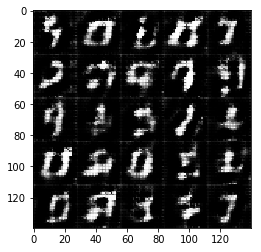

Epoch 1/2... Discriminator Loss: 0.3116... Generator Loss: 2.1792
Epoch 1/2... Discriminator Loss: 6.3036... Generator Loss: 0.8966


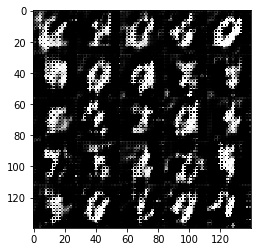

Epoch 1/2... Discriminator Loss: 3.8223... Generator Loss: 0.0574
Epoch 1/2... Discriminator Loss: 0.1463... Generator Loss: 3.0241
Epoch 1/2... Discriminator Loss: 0.0640... Generator Loss: 3.7052


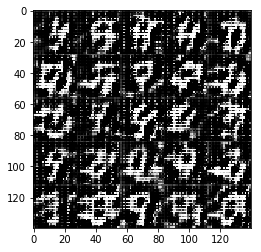

Epoch 1/2... Discriminator Loss: 0.0868... Generator Loss: 3.1633
Epoch 1/2... Discriminator Loss: 0.0305... Generator Loss: 5.6805


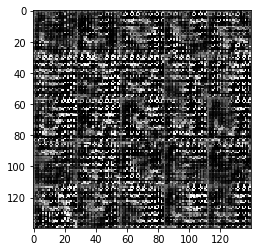

Epoch 1/2... Discriminator Loss: 2.2598... Generator Loss: 1.1141
Epoch 1/2... Discriminator Loss: 0.4614... Generator Loss: 2.9279
Epoch 1/2... Discriminator Loss: 0.6537... Generator Loss: 4.8493


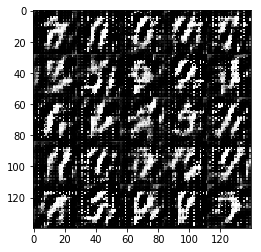

Epoch 1/2... Discriminator Loss: 0.8367... Generator Loss: 1.7335
Epoch 1/2... Discriminator Loss: 0.2267... Generator Loss: 4.0271


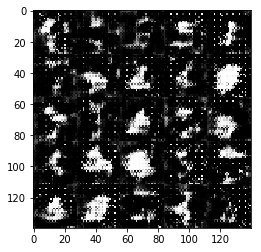

Epoch 1/2... Discriminator Loss: 0.1425... Generator Loss: 3.3353
Epoch 1/2... Discriminator Loss: 0.6450... Generator Loss: 3.0827
Epoch 1/2... Discriminator Loss: 2.8940... Generator Loss: 0.1446


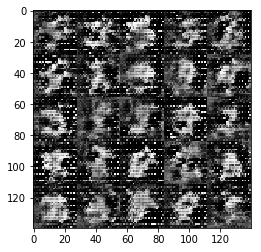

Epoch 1/2... Discriminator Loss: 2.9536... Generator Loss: 0.1518
Epoch 1/2... Discriminator Loss: 1.5479... Generator Loss: 0.7016


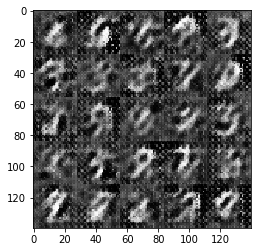

Epoch 1/2... Discriminator Loss: 1.6950... Generator Loss: 0.3081
Epoch 1/2... Discriminator Loss: 2.1584... Generator Loss: 0.2594
Epoch 1/2... Discriminator Loss: 0.9115... Generator Loss: 1.8759


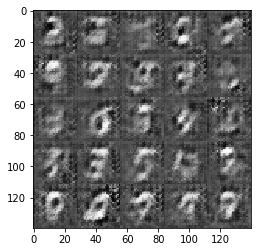

Epoch 1/2... Discriminator Loss: 1.1653... Generator Loss: 0.5788
Epoch 1/2... Discriminator Loss: 1.0887... Generator Loss: 0.6077


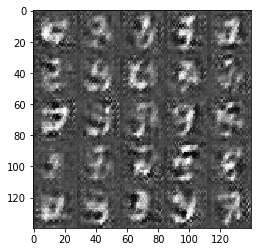

Epoch 1/2... Discriminator Loss: 0.8807... Generator Loss: 1.6718
Epoch 1/2... Discriminator Loss: 0.9482... Generator Loss: 2.0299
Epoch 1/2... Discriminator Loss: 1.0890... Generator Loss: 1.4737


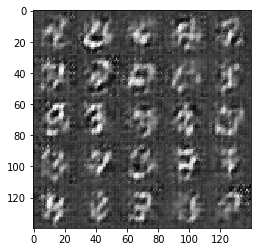

Epoch 1/2... Discriminator Loss: 0.7259... Generator Loss: 1.4830
Epoch 1/2... Discriminator Loss: 0.8270... Generator Loss: 2.1028


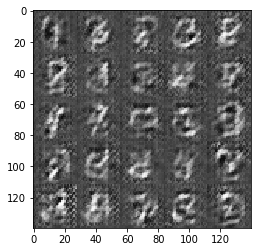

Epoch 1/2... Discriminator Loss: 1.4441... Generator Loss: 0.3441
Epoch 1/2... Discriminator Loss: 1.2072... Generator Loss: 3.3564
Epoch 1/2... Discriminator Loss: 0.6594... Generator Loss: 1.0267


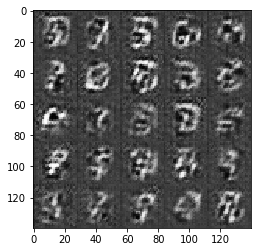

Epoch 1/2... Discriminator Loss: 0.7632... Generator Loss: 1.8593
Epoch 1/2... Discriminator Loss: 1.1264... Generator Loss: 0.5065


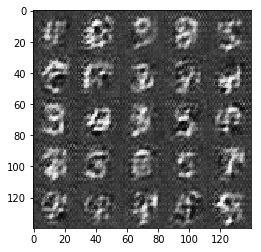

Epoch 1/2... Discriminator Loss: 0.5756... Generator Loss: 1.9985
Epoch 1/2... Discriminator Loss: 0.5913... Generator Loss: 2.7584
Epoch 1/2... Discriminator Loss: 1.1738... Generator Loss: 2.6393


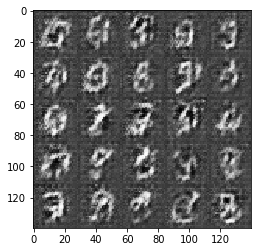

Epoch 1/2... Discriminator Loss: 0.5035... Generator Loss: 1.3638
Epoch 1/2... Discriminator Loss: 2.2707... Generator Loss: 5.4328


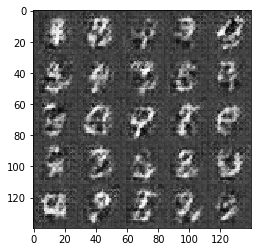

Epoch 1/2... Discriminator Loss: 0.6668... Generator Loss: 3.1943
Epoch 1/2... Discriminator Loss: 0.2976... Generator Loss: 1.6988
Epoch 1/2... Discriminator Loss: 0.2735... Generator Loss: 1.8429


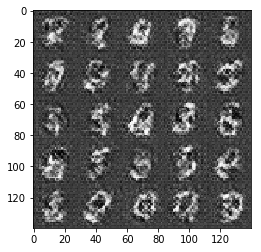

Epoch 1/2... Discriminator Loss: 0.2234... Generator Loss: 2.0415
Epoch 2/2... Discriminator Loss: 0.1159... Generator Loss: 3.2607


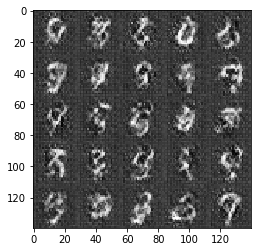

Epoch 2/2... Discriminator Loss: 0.1695... Generator Loss: 2.6521
Epoch 2/2... Discriminator Loss: 1.9141... Generator Loss: 0.2986
Epoch 2/2... Discriminator Loss: 1.1263... Generator Loss: 2.6186


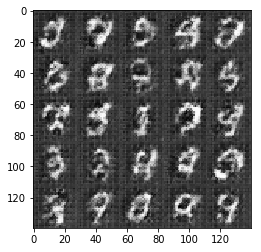

Epoch 2/2... Discriminator Loss: 0.7242... Generator Loss: 0.8824
Epoch 2/2... Discriminator Loss: 0.4292... Generator Loss: 1.7476


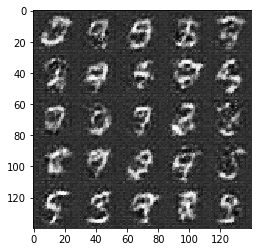

Epoch 2/2... Discriminator Loss: 0.3954... Generator Loss: 1.4853
Epoch 2/2... Discriminator Loss: 0.3392... Generator Loss: 1.8890
Epoch 2/2... Discriminator Loss: 0.3151... Generator Loss: 2.2156


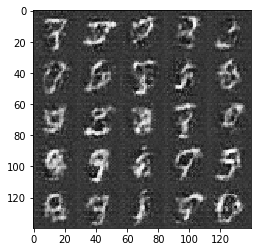

Epoch 2/2... Discriminator Loss: 1.6774... Generator Loss: 0.2825
Epoch 2/2... Discriminator Loss: 0.5246... Generator Loss: 1.6797


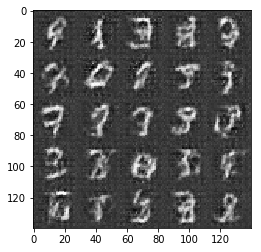

Epoch 2/2... Discriminator Loss: 2.2768... Generator Loss: 5.0018
Epoch 2/2... Discriminator Loss: 0.7614... Generator Loss: 0.9082
Epoch 2/2... Discriminator Loss: 0.4060... Generator Loss: 1.5287


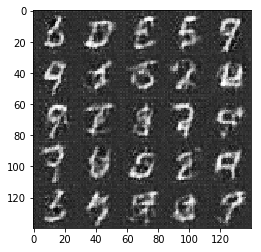

Epoch 2/2... Discriminator Loss: 0.3098... Generator Loss: 1.7777
Epoch 2/2... Discriminator Loss: 0.3435... Generator Loss: 1.7224


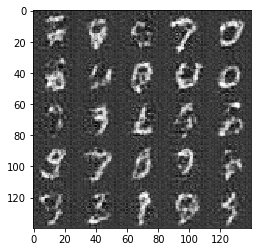

Epoch 2/2... Discriminator Loss: 0.1710... Generator Loss: 2.6493
Epoch 2/2... Discriminator Loss: 0.2164... Generator Loss: 2.4103
Epoch 2/2... Discriminator Loss: 0.0669... Generator Loss: 4.5465


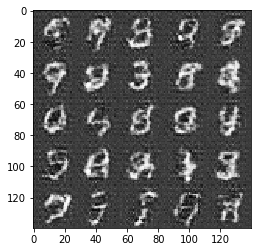

Epoch 2/2... Discriminator Loss: 3.8242... Generator Loss: 5.1380
Epoch 2/2... Discriminator Loss: 1.6619... Generator Loss: 2.2789


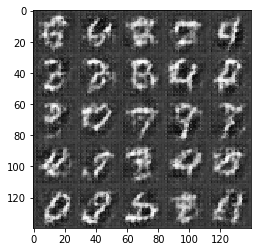

Epoch 2/2... Discriminator Loss: 1.1804... Generator Loss: 1.9364
Epoch 2/2... Discriminator Loss: 1.7761... Generator Loss: 0.2817
Epoch 2/2... Discriminator Loss: 1.0698... Generator Loss: 0.5605


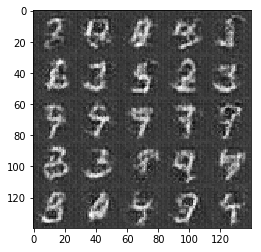

Epoch 2/2... Discriminator Loss: 0.4927... Generator Loss: 1.3967
Epoch 2/2... Discriminator Loss: 0.4382... Generator Loss: 1.9912


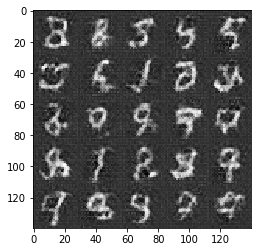

Epoch 2/2... Discriminator Loss: 0.7807... Generator Loss: 0.7781
Epoch 2/2... Discriminator Loss: 0.6775... Generator Loss: 1.0152
Epoch 2/2... Discriminator Loss: 1.5462... Generator Loss: 0.3164


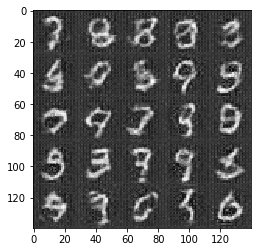

Epoch 2/2... Discriminator Loss: 0.5813... Generator Loss: 1.7721
Epoch 2/2... Discriminator Loss: 0.4163... Generator Loss: 1.7665


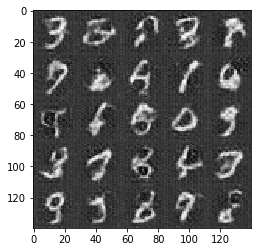

Epoch 2/2... Discriminator Loss: 0.4778... Generator Loss: 1.3390
Epoch 2/2... Discriminator Loss: 0.2466... Generator Loss: 2.1098
Epoch 2/2... Discriminator Loss: 0.1376... Generator Loss: 2.7419


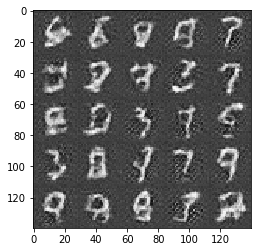

Epoch 2/2... Discriminator Loss: 0.0961... Generator Loss: 2.9125
Epoch 2/2... Discriminator Loss: 0.0301... Generator Loss: 4.6308


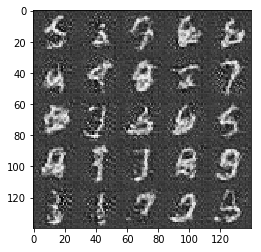

Epoch 2/2... Discriminator Loss: 0.0222... Generator Loss: 5.2225
Epoch 2/2... Discriminator Loss: 0.1009... Generator Loss: 3.5242
Epoch 2/2... Discriminator Loss: 0.0294... Generator Loss: 4.7087


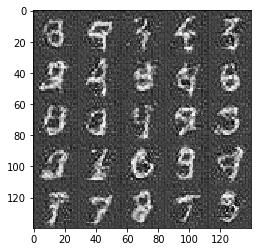

Epoch 2/2... Discriminator Loss: 0.0513... Generator Loss: 3.5342
Epoch 2/2... Discriminator Loss: 0.0830... Generator Loss: 3.0354


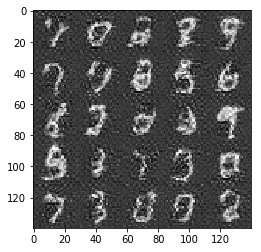

Epoch 2/2... Discriminator Loss: 0.1814... Generator Loss: 2.2199
Epoch 2/2... Discriminator Loss: 0.0349... Generator Loss: 7.3019
Epoch 2/2... Discriminator Loss: 0.0086... Generator Loss: 7.0875


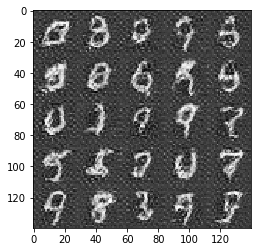

Epoch 2/2... Discriminator Loss: 0.2280... Generator Loss: 2.0571
Epoch 2/2... Discriminator Loss: 1.1483... Generator Loss: 1.9587


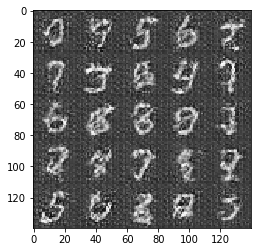

Epoch 2/2... Discriminator Loss: 0.8418... Generator Loss: 0.8636


In [45]:
batch_size = 128
z_dim = 100
learning_rate = 0.01
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.9633... Generator Loss: 0.3287
Epoch 1/1... Discriminator Loss: 3.0473... Generator Loss: 0.0818


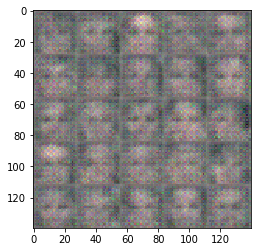

Epoch 1/1... Discriminator Loss: 0.8016... Generator Loss: 0.8574
Epoch 1/1... Discriminator Loss: 0.6703... Generator Loss: 0.9612
Epoch 1/1... Discriminator Loss: 0.1458... Generator Loss: 3.2128


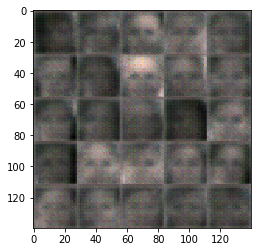

Epoch 1/1... Discriminator Loss: 3.3992... Generator Loss: 11.1670
Epoch 1/1... Discriminator Loss: 0.6679... Generator Loss: 5.2348


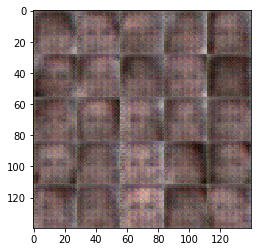

Epoch 1/1... Discriminator Loss: 0.2861... Generator Loss: 6.4299
Epoch 1/1... Discriminator Loss: 1.7657... Generator Loss: 0.2419
Epoch 1/1... Discriminator Loss: 0.5073... Generator Loss: 1.6319


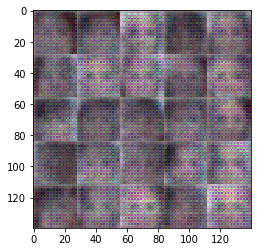

Epoch 1/1... Discriminator Loss: 0.1548... Generator Loss: 2.5994
Epoch 1/1... Discriminator Loss: 2.6306... Generator Loss: 0.1539


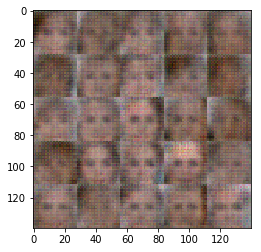

Epoch 1/1... Discriminator Loss: 0.2179... Generator Loss: 2.7829
Epoch 1/1... Discriminator Loss: 1.3715... Generator Loss: 0.3908
Epoch 1/1... Discriminator Loss: 0.5384... Generator Loss: 1.1342


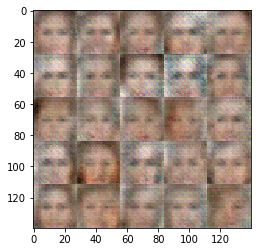

Epoch 1/1... Discriminator Loss: 0.9262... Generator Loss: 0.9061
Epoch 1/1... Discriminator Loss: 1.4294... Generator Loss: 0.3434


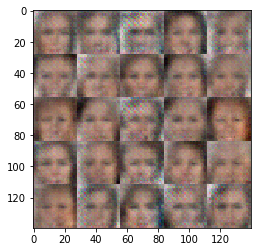

Epoch 1/1... Discriminator Loss: 0.1528... Generator Loss: 5.6702
Epoch 1/1... Discriminator Loss: 0.3497... Generator Loss: 8.7164
Epoch 1/1... Discriminator Loss: 1.1926... Generator Loss: 0.4603


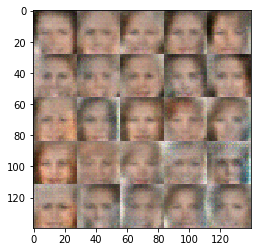

Epoch 1/1... Discriminator Loss: 0.2020... Generator Loss: 7.2045
Epoch 1/1... Discriminator Loss: 0.3355... Generator Loss: 5.8688


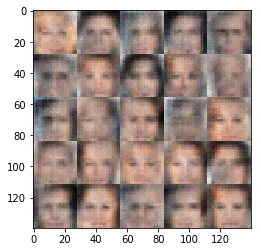

Epoch 1/1... Discriminator Loss: 0.2545... Generator Loss: 3.7472
Epoch 1/1... Discriminator Loss: 1.3684... Generator Loss: 0.5794
Epoch 1/1... Discriminator Loss: 1.2523... Generator Loss: 0.5722


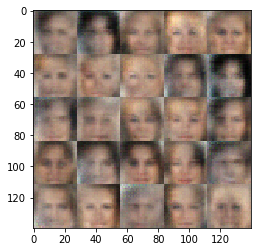

Epoch 1/1... Discriminator Loss: 1.6449... Generator Loss: 0.3004
Epoch 1/1... Discriminator Loss: 1.6775... Generator Loss: 3.1833


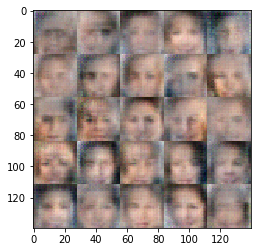

Epoch 1/1... Discriminator Loss: 1.4653... Generator Loss: 0.3699
Epoch 1/1... Discriminator Loss: 0.3465... Generator Loss: 4.8611
Epoch 1/1... Discriminator Loss: 0.3874... Generator Loss: 5.3101


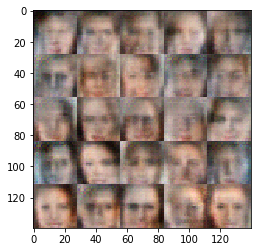

Epoch 1/1... Discriminator Loss: 0.2995... Generator Loss: 2.5925
Epoch 1/1... Discriminator Loss: 0.4287... Generator Loss: 2.3557


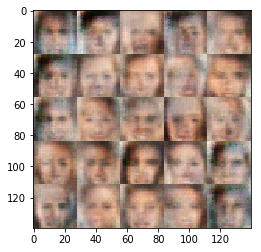

Epoch 1/1... Discriminator Loss: 0.8830... Generator Loss: 4.8347
Epoch 1/1... Discriminator Loss: 0.4612... Generator Loss: 1.4542
Epoch 1/1... Discriminator Loss: 0.3936... Generator Loss: 2.6050


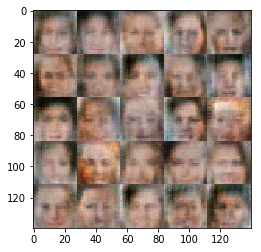

Epoch 1/1... Discriminator Loss: 0.2773... Generator Loss: 6.0145
Epoch 1/1... Discriminator Loss: 0.2526... Generator Loss: 5.8171


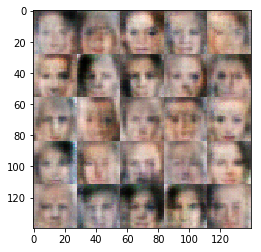

Epoch 1/1... Discriminator Loss: 1.4649... Generator Loss: 5.9174
Epoch 1/1... Discriminator Loss: 0.6551... Generator Loss: 2.4280
Epoch 1/1... Discriminator Loss: 1.1207... Generator Loss: 0.5140


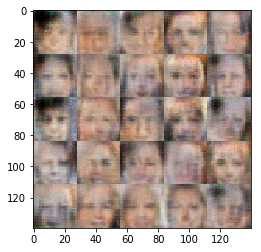

Epoch 1/1... Discriminator Loss: 0.4081... Generator Loss: 4.2094
Epoch 1/1... Discriminator Loss: 0.3373... Generator Loss: 6.7903


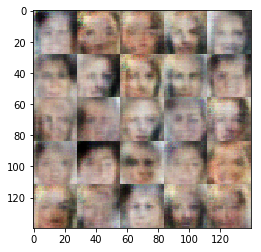

Epoch 1/1... Discriminator Loss: 0.1557... Generator Loss: 8.0430
Epoch 1/1... Discriminator Loss: 0.3483... Generator Loss: 5.0942
Epoch 1/1... Discriminator Loss: 0.9555... Generator Loss: 0.6836


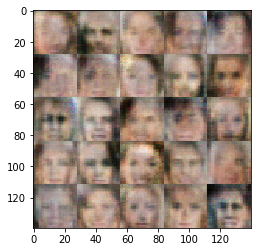

Epoch 1/1... Discriminator Loss: 1.0019... Generator Loss: 1.0932
Epoch 1/1... Discriminator Loss: 0.5146... Generator Loss: 6.9976


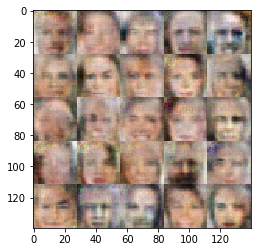

Epoch 1/1... Discriminator Loss: 0.3232... Generator Loss: 3.1143
Epoch 1/1... Discriminator Loss: 0.3997... Generator Loss: 3.1780
Epoch 1/1... Discriminator Loss: 0.3174... Generator Loss: 5.0751


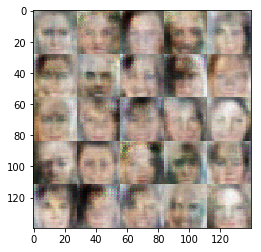

Epoch 1/1... Discriminator Loss: 1.4988... Generator Loss: 1.4588
Epoch 1/1... Discriminator Loss: 0.3138... Generator Loss: 3.2684


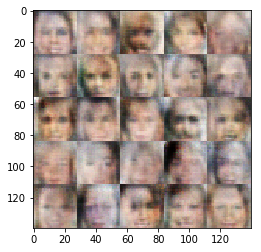

Epoch 1/1... Discriminator Loss: 0.1726... Generator Loss: 3.4861
Epoch 1/1... Discriminator Loss: 0.5608... Generator Loss: 6.8792
Epoch 1/1... Discriminator Loss: 0.7935... Generator Loss: 0.7714


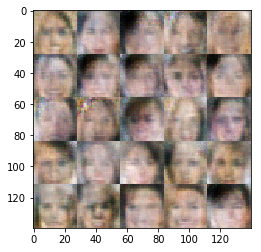

Epoch 1/1... Discriminator Loss: 0.3909... Generator Loss: 1.9487
Epoch 1/1... Discriminator Loss: 0.4648... Generator Loss: 1.7685


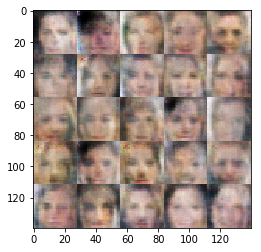

Epoch 1/1... Discriminator Loss: 0.7339... Generator Loss: 0.9736
Epoch 1/1... Discriminator Loss: 1.7389... Generator Loss: 0.9058
Epoch 1/1... Discriminator Loss: 0.3957... Generator Loss: 3.6209


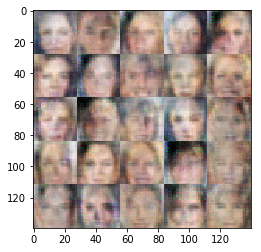

Epoch 1/1... Discriminator Loss: 1.0087... Generator Loss: 0.7946
Epoch 1/1... Discriminator Loss: 1.0008... Generator Loss: 0.6700


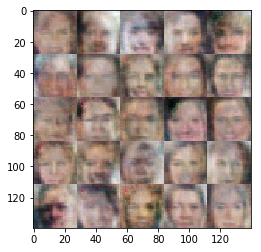

Epoch 1/1... Discriminator Loss: 0.9702... Generator Loss: 0.7127
Epoch 1/1... Discriminator Loss: 0.4591... Generator Loss: 4.2315
Epoch 1/1... Discriminator Loss: 0.2741... Generator Loss: 3.2001


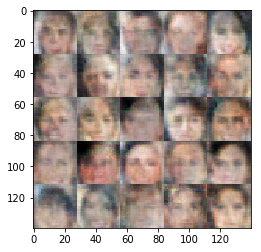

Epoch 1/1... Discriminator Loss: 1.5293... Generator Loss: 1.7828
Epoch 1/1... Discriminator Loss: 0.7629... Generator Loss: 0.9423


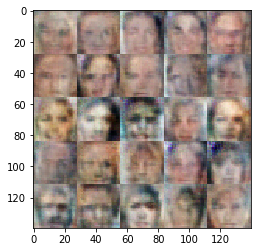

Epoch 1/1... Discriminator Loss: 1.3480... Generator Loss: 0.4265
Epoch 1/1... Discriminator Loss: 0.4778... Generator Loss: 2.1049
Epoch 1/1... Discriminator Loss: 0.4391... Generator Loss: 3.2824


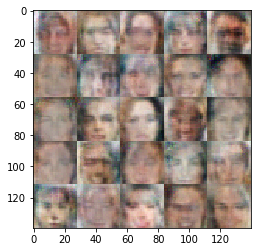

Epoch 1/1... Discriminator Loss: 1.2426... Generator Loss: 0.6078
Epoch 1/1... Discriminator Loss: 0.5221... Generator Loss: 1.5571


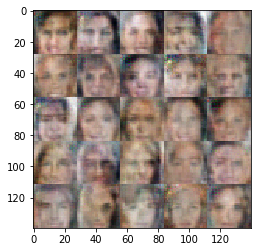

Epoch 1/1... Discriminator Loss: 0.8945... Generator Loss: 0.7281
Epoch 1/1... Discriminator Loss: 0.9585... Generator Loss: 0.7128
Epoch 1/1... Discriminator Loss: 3.3363... Generator Loss: 1.9710


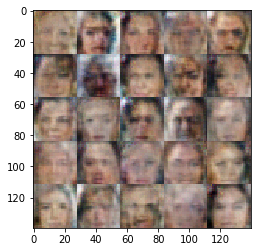

Epoch 1/1... Discriminator Loss: 0.4910... Generator Loss: 1.9676
Epoch 1/1... Discriminator Loss: 0.4300... Generator Loss: 3.1195


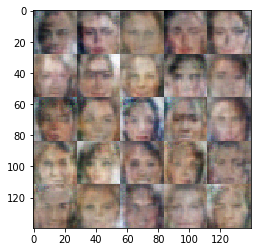

Epoch 1/1... Discriminator Loss: 0.2177... Generator Loss: 4.2860
Epoch 1/1... Discriminator Loss: 0.7275... Generator Loss: 1.0336
Epoch 1/1... Discriminator Loss: 0.5928... Generator Loss: 1.6222


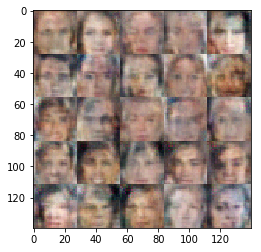

Epoch 1/1... Discriminator Loss: 0.6781... Generator Loss: 1.3278
Epoch 1/1... Discriminator Loss: 0.4853... Generator Loss: 2.6921


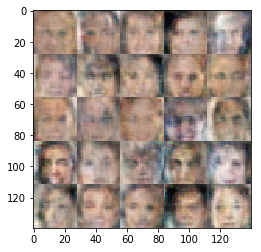

Epoch 1/1... Discriminator Loss: 0.4993... Generator Loss: 1.7449
Epoch 1/1... Discriminator Loss: 0.5269... Generator Loss: 1.6746
Epoch 1/1... Discriminator Loss: 0.3724... Generator Loss: 2.6788


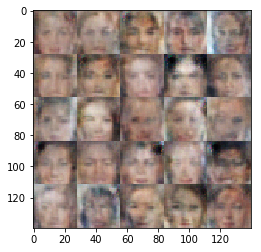

Epoch 1/1... Discriminator Loss: 2.4634... Generator Loss: 3.7727
Epoch 1/1... Discriminator Loss: 2.9463... Generator Loss: 0.1113


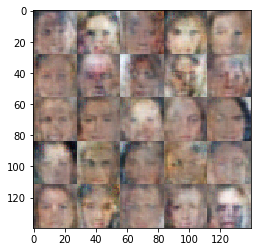

Epoch 1/1... Discriminator Loss: 2.4239... Generator Loss: 2.4823
Epoch 1/1... Discriminator Loss: 0.7637... Generator Loss: 2.5013
Epoch 1/1... Discriminator Loss: 0.9719... Generator Loss: 1.9919


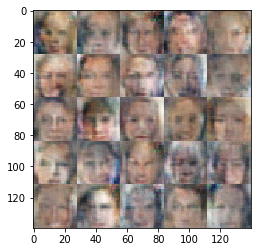

Epoch 1/1... Discriminator Loss: 1.0820... Generator Loss: 3.0666
Epoch 1/1... Discriminator Loss: 1.5995... Generator Loss: 1.2322


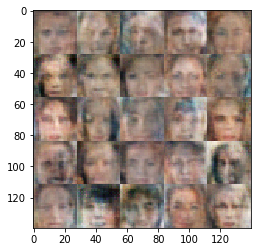

Epoch 1/1... Discriminator Loss: 0.3348... Generator Loss: 6.2500
Epoch 1/1... Discriminator Loss: 0.9852... Generator Loss: 0.8368
Epoch 1/1... Discriminator Loss: 1.0528... Generator Loss: 0.6588


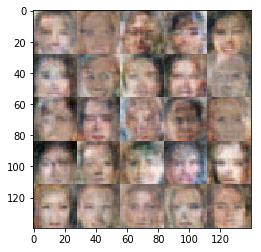

Epoch 1/1... Discriminator Loss: 0.3740... Generator Loss: 2.5671
Epoch 1/1... Discriminator Loss: 0.8492... Generator Loss: 0.8317


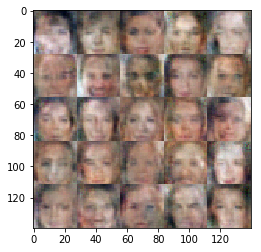

Epoch 1/1... Discriminator Loss: 0.2944... Generator Loss: 3.1539
Epoch 1/1... Discriminator Loss: 0.4729... Generator Loss: 1.6497
Epoch 1/1... Discriminator Loss: 1.0840... Generator Loss: 1.0443


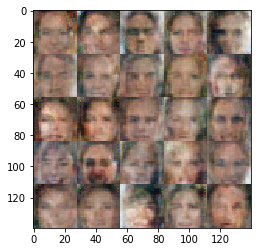

Epoch 1/1... Discriminator Loss: 0.6176... Generator Loss: 2.8160
Epoch 1/1... Discriminator Loss: 1.0042... Generator Loss: 0.7271


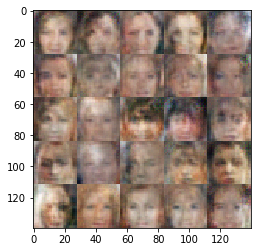

Epoch 1/1... Discriminator Loss: 0.6414... Generator Loss: 1.5302
Epoch 1/1... Discriminator Loss: 0.4237... Generator Loss: 4.4108
Epoch 1/1... Discriminator Loss: 0.7722... Generator Loss: 1.0332


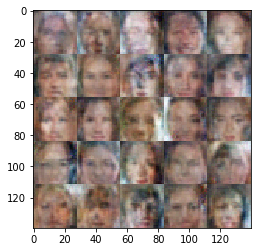

Epoch 1/1... Discriminator Loss: 0.1690... Generator Loss: 3.4363
Epoch 1/1... Discriminator Loss: 0.2599... Generator Loss: 2.7770


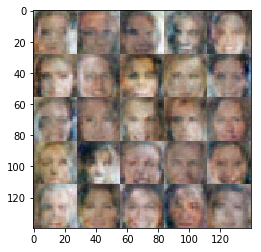

Epoch 1/1... Discriminator Loss: 0.3347... Generator Loss: 5.3172
Epoch 1/1... Discriminator Loss: 2.3719... Generator Loss: 0.5107
Epoch 1/1... Discriminator Loss: 1.8768... Generator Loss: 1.8732


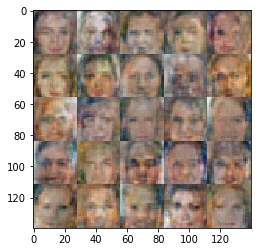

Epoch 1/1... Discriminator Loss: 1.3468... Generator Loss: 1.2354
Epoch 1/1... Discriminator Loss: 0.9249... Generator Loss: 1.6671


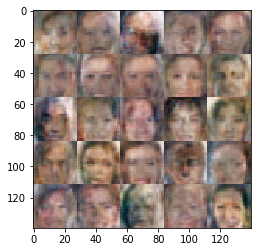

Epoch 1/1... Discriminator Loss: 1.7286... Generator Loss: 1.4869
Epoch 1/1... Discriminator Loss: 0.9693... Generator Loss: 0.7390
Epoch 1/1... Discriminator Loss: 0.6190... Generator Loss: 1.7210


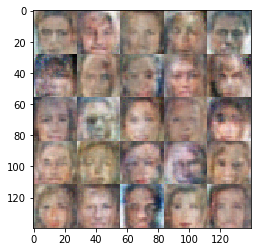

Epoch 1/1... Discriminator Loss: 0.8719... Generator Loss: 1.5570
Epoch 1/1... Discriminator Loss: 1.5177... Generator Loss: 0.4729


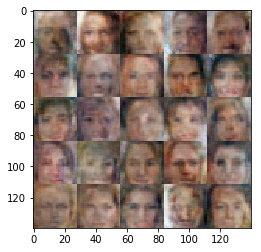

Epoch 1/1... Discriminator Loss: 1.1443... Generator Loss: 2.0667
Epoch 1/1... Discriminator Loss: 0.5524... Generator Loss: 2.1163
Epoch 1/1... Discriminator Loss: 0.5151... Generator Loss: 4.0244


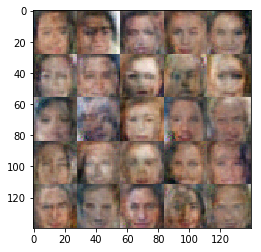

Epoch 1/1... Discriminator Loss: 1.7229... Generator Loss: 1.5843
Epoch 1/1... Discriminator Loss: 0.7255... Generator Loss: 1.0905


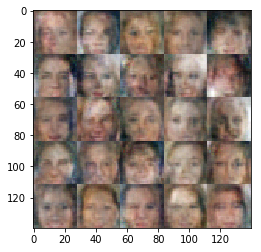

Epoch 1/1... Discriminator Loss: 0.9842... Generator Loss: 1.3036
Epoch 1/1... Discriminator Loss: 1.7055... Generator Loss: 3.4790
Epoch 1/1... Discriminator Loss: 0.6580... Generator Loss: 1.2841


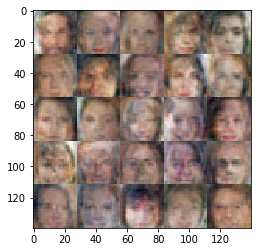

Epoch 1/1... Discriminator Loss: 1.0365... Generator Loss: 0.6341
Epoch 1/1... Discriminator Loss: 0.5829... Generator Loss: 1.8004


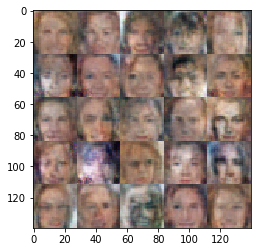

Epoch 1/1... Discriminator Loss: 0.4040... Generator Loss: 3.0998
Epoch 1/1... Discriminator Loss: 1.1276... Generator Loss: 1.4071
Epoch 1/1... Discriminator Loss: 2.1719... Generator Loss: 1.6959


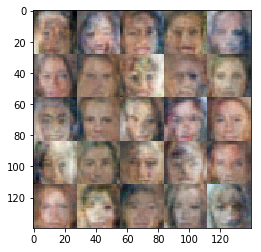

Epoch 1/1... Discriminator Loss: 0.5126... Generator Loss: 2.1650
Epoch 1/1... Discriminator Loss: 1.5887... Generator Loss: 3.8479


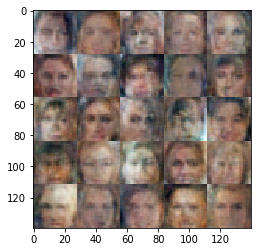

Epoch 1/1... Discriminator Loss: 1.2137... Generator Loss: 0.7916
Epoch 1/1... Discriminator Loss: 0.4997... Generator Loss: 3.3728
Epoch 1/1... Discriminator Loss: 1.3343... Generator Loss: 1.0320


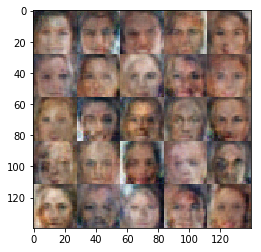

Epoch 1/1... Discriminator Loss: 0.9503... Generator Loss: 0.7612
Epoch 1/1... Discriminator Loss: 0.3747... Generator Loss: 2.4435


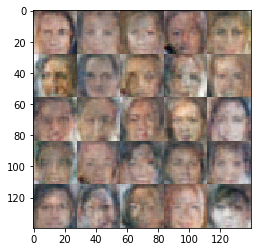

Epoch 1/1... Discriminator Loss: 0.6813... Generator Loss: 1.2729
Epoch 1/1... Discriminator Loss: 0.7192... Generator Loss: 1.2101
Epoch 1/1... Discriminator Loss: 0.3842... Generator Loss: 2.2169


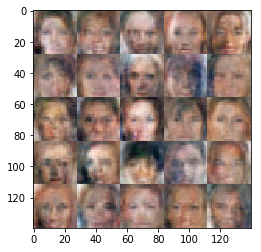

Epoch 1/1... Discriminator Loss: 2.6286... Generator Loss: 1.8317
Epoch 1/1... Discriminator Loss: 0.5556... Generator Loss: 2.4031


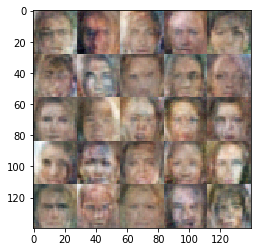

Epoch 1/1... Discriminator Loss: 1.4669... Generator Loss: 0.6012
Epoch 1/1... Discriminator Loss: 0.5686... Generator Loss: 1.3283
Epoch 1/1... Discriminator Loss: 1.1177... Generator Loss: 0.7100


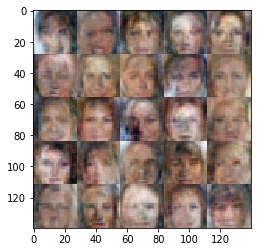

Epoch 1/1... Discriminator Loss: 1.0367... Generator Loss: 1.3314
Epoch 1/1... Discriminator Loss: 0.3840... Generator Loss: 2.1571


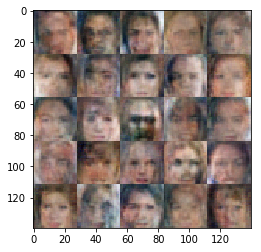

Epoch 1/1... Discriminator Loss: 0.3119... Generator Loss: 3.5599
Epoch 1/1... Discriminator Loss: 0.4314... Generator Loss: 2.0227
Epoch 1/1... Discriminator Loss: 0.7526... Generator Loss: 1.6447


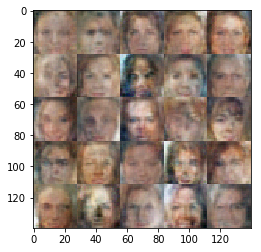

Epoch 1/1... Discriminator Loss: 0.3042... Generator Loss: 2.6949
Epoch 1/1... Discriminator Loss: 0.2872... Generator Loss: 2.3627


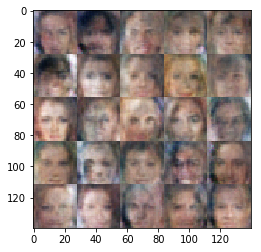

Epoch 1/1... Discriminator Loss: 2.7060... Generator Loss: 3.7606
Epoch 1/1... Discriminator Loss: 1.5858... Generator Loss: 0.4349
Epoch 1/1... Discriminator Loss: 0.8222... Generator Loss: 0.9584


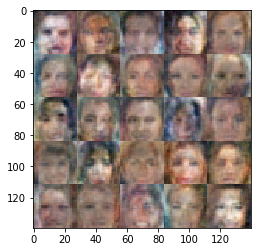

Epoch 1/1... Discriminator Loss: 1.3970... Generator Loss: 0.4128
Epoch 1/1... Discriminator Loss: 1.2101... Generator Loss: 1.3903


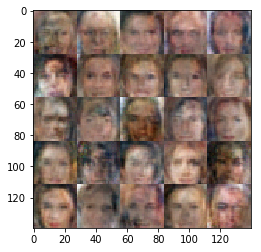

Epoch 1/1... Discriminator Loss: 1.0029... Generator Loss: 1.1423


In [46]:
batch_size = 128
z_dim = 100
learning_rate = 0.001
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.